In [704]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [705]:
from google.colab import drive, files
drive.mount('/content/drive')
rootpath = '/content/drive/Shareddrives/KW phase1 repo'
import sys
sys.path.append(rootpath+'/package')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [706]:
import cvxpy as cp
from utils.env import env
from model.sdp import SDP
from model.pathlossmodel import PathLossModel, NoiseMaker
from service.measurerss import measureRSS

In [707]:
div = 100
pick = 3
model="VAE"
fileFolder = "/0808_3_v2"

### Read final anomaly detection results

In [708]:
import pickle as dill
_UAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalySDPResult"+fileFolder+"/UAVsSamples_pick{}div{}_300.npy".format(pick,div), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _UAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
UAVsSamples = _UAVsSamples
print(UAVsSamples)

{0: {0: <model.uav.UAV object at 0x7fb3a8e9b9d0>, 1: <model.uav.UAV object at 0x7fb3a9f6b750>, 2: <model.uav.UAV object at 0x7fb3a9321510>, 3: <model.uav.UAV object at 0x7fb3a93210d0>, 4: <model.uav.UAV object at 0x7fb3a9321950>, 5: <model.uav.UAV object at 0x7fb3aa09c2d0>, 6: <model.uav.UAV object at 0x7fb3a9a8df90>, 7: <model.uav.UAV object at 0x7fb3a9a8df10>, 8: <model.uav.UAV object at 0x7fb3a9a8dc10>, 9: <model.uav.UAV object at 0x7fb3a9a8de10>, 10: <model.uav.UAV object at 0x7fb3a9a8df50>, 11: <model.uav.UAV object at 0x7fb3a944ac50>, 12: <model.uav.UAV object at 0x7fb3a8ee6150>, 13: <model.uav.UAV object at 0x7fb3a8ee6cd0>, 14: <model.uav.UAV object at 0x7fb3a8ee6050>, 15: <model.uav.UAV object at 0x7fb3a9ad8150>}, 1: {0: <model.uav.UAV object at 0x7fb3a8e9b6d0>, 1: <model.uav.UAV object at 0x7fb3a9183c90>, 2: <model.uav.UAV object at 0x7fb3a9183c50>, 3: <model.uav.UAV object at 0x7fb3a9e2f890>, 4: <model.uav.UAV object at 0x7fb3aa545b10>, 5: <model.uav.UAV object at 0x7fb3a8c01

In [709]:
pathLossModel = PathLossModel()
pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = env.noiseDeviation)

In [710]:
Samples = len(UAVsSamples)
print("Samples : ", Samples)

Samples :  79


In [711]:
OriginAnchors = {}
OriginTargets = {}
for iSample in UAVsSamples:
  originAnchorsOfSample = []
  originTargetsOfSample = []
  for iUAVOfSample in UAVsSamples[iSample]:
    if UAVsSamples[iSample][iUAVOfSample].observedPosition == None:
      originTargetsOfSample.append(UAVsSamples[iSample][iUAVOfSample])
    else:
      originAnchorsOfSample.append(UAVsSamples[iSample][iUAVOfSample])
  OriginAnchors[iSample] = originAnchorsOfSample
  OriginTargets[iSample] = originTargetsOfSample

In [712]:
anomalyUAVsSample = {}
for iSample in UAVsSamples:
  anomalyUAV = []
  for IDOfUAV in UAVsSamples[iSample]:
    uav = UAVsSamples[iSample][IDOfUAV]
    if not uav.observedPosition == None:
      if not uav.observedPosition == uav.realPosition:
        anomalyUAV.append(IDOfUAV)
  anomalyUAVsSample[iSample] = anomalyUAV
anomalyUAVs = [anomalyUAVsSample]

In [713]:
OriginAnchors = OriginAnchors
OriginTargets = OriginTargets

In [714]:
import pickle
f = open(rootpath+"/datas/datas_forAnomalyDetection/BestAnchors/0808_3_100sample_{}anomaly_{}div_SelectedAnchors_{}_v2.pkl".format(pick,div,model), "rb")
goodUAVsSample = pickle.load(f)
f.close()

In [715]:
SelectedAnchors = {}
SelectedTargets = {}
for iSample in goodUAVsSample:
  selectedAnchorsOfSample = []
  selectedTargetsOfSample = []
  for IDOfUAV in UAVsSamples[iSample]:
    if IDOfUAV in goodUAVsSample[iSample]:
      selectedAnchorsOfSample.append(UAVsSamples[iSample][IDOfUAV])
    else:
      selectedTargetsOfSample.append(UAVsSamples[iSample][IDOfUAV])
  SelectedAnchors[iSample] = selectedAnchorsOfSample
  SelectedTargets[iSample] = selectedTargetsOfSample

In [716]:
SelectedAnchors = SelectedAnchors
SelectedTargets = SelectedTargets

### Calculate SOC-SDP

In [717]:
EstimatedPositionBeforeAnomalyDetection = {}
for Sample in range(Samples):
  print("#{:3d}".format(Sample))
  sdp = SDP()
  sdp.var_SOCPt = cp.Variable(1)
  sdp.var_SDPt = cp.Variable(1)
  sdp.var_p = [cp.Variable((env.DIMENSION+1, env.DIMENSION+1), symmetric=True) for i in range(len(OriginTargets[Sample]))]
  
  sdp.buildConstraint(OriginTargets[Sample], OriginAnchors[Sample], pathLossModel)
  sdp.doSolve(log=False)
  targetPositions = [sdp.var_p[i].value[-1][:3] for i in range(len(OriginTargets[Sample]))]
  EstimatedPositionBeforeAnomalyDetection[Sample] = targetPositions

#  0
#  1
#  2
#  3
#  4
#  5
#  6
#  7
#  8
#  9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19
# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78


In [718]:
EstimatedPositionAfterAnomalyDetection = {}
for Sample in range(Samples):
  print("#{:3d}".format(Sample))
  sdp = SDP()
  sdp.var_SOCPt = cp.Variable(1)
  sdp.var_SDPt = cp.Variable(1)
  sdp.var_p = [cp.Variable((env.DIMENSION+1, env.DIMENSION+1), symmetric=True) for i in range(len(SelectedTargets[Sample]))]
  
  if not len(SelectedAnchors[Sample]) == 0:
    sdp.buildConstraint(SelectedTargets[Sample], SelectedAnchors[Sample], pathLossModel)
    sdp.doSolve(log=False)
    targetPositions = [sdp.var_p[i].value[-1][:3] for i in range(len(SelectedTargets[Sample]))]
    EstimatedPositionAfterAnomalyDetection[Sample] = targetPositions

#  0
#  1
#  2
#  3
#  4
#  5
#  6
#  7
#  8
#  9
# 10
# 11
# 12
# 13
# 14
# 15
# 16
# 17
# 18
# 19
# 20
# 21
# 22
# 23
# 24
# 25
# 26
# 27
# 28
# 29
# 30
# 31
# 32
# 33
# 34
# 35
# 36
# 37
# 38
# 39
# 40
# 41
# 42
# 43
# 44
# 45
# 46
# 47
# 48
# 49
# 50
# 51
# 52
# 53
# 54
# 55
# 56
# 57
# 58
# 59
# 60
# 61
# 62
# 63
# 64
# 65
# 66
# 67
# 68
# 69
# 70
# 71
# 72
# 73
# 74
# 75
# 76
# 77
# 78


### Plot SOC-SDP result and localization RMSE

In [719]:
import datetime, os
now = datetime.datetime.now()
month = '{:02d}'.format(now.month)
day = '{:02d}'.format(now.day)

In [720]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection='3d')
# ax.set_xlim([0, 1500])
# ax.set_ylim([0, 1500])
# ax.set_zlim([0, 1500])
# ax.set_xlabel('x-axis (m)', fontsize=20, labelpad=22)
# ax.set_ylabel('y-axis (m)', fontsize=20, labelpad=20)
# ax.set_zlabel('z-axis (m)', fontsize=20, labelpad=18)
# ax.tick_params(axis='x', labelsize=18, labelrotation = 20)
# ax.tick_params(axis='y', labelsize=18, labelrotation = -20)
# ax.tick_params(axis='z', pad=10, labelsize=18)
# plt.grid()

# scatters = []
# scattersLegends = []

# sample = 45

# for originAnchor in OriginAnchors[sample]:
#   p = originAnchor.realPosition
#   if originAnchor.realPosition == originAnchor.observedPosition:
#     scatter1 = ax.scatter(p[0], p[1], p[2], c='#FF0000', marker='*', s=64, alpha=1)
#   else:
#     scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='^', s=64, alpha=1)
#     scatter_anomalyPosition = ax.scatter(originAnchor.observedPosition[0], originAnchor.observedPosition[1], originAnchor.observedPosition[2], c='orange', marker='^', s=64, alpha=1)
# scatters.append(scatter1)
# scattersLegends.append("Normal anchor")
# scatters.append(scatter_anomaly)
# scattersLegends.append("True position of anomaly anchor")
# scatters.append(scatter_anomalyPosition)
# scattersLegends.append("Reported position of anomaly anchor")

# for originTarget in OriginTargets[sample]:
#   p = originTarget.realPosition
#   scatter2 = ax.scatter(p[0], p[1], p[2], c='#0000FF', marker='x', s=64, alpha=1)
# scatters.append(scatter2)
# scattersLegends.append("Target")

# for i, estimatedPosition in enumerate(EstimatedPositionBeforeAnomalyDetection[sample]):
#   p = estimatedPosition
#   scatter3 = ax.scatter(p[0], p[1], p[2], c='#00FF00', marker='o', s=64, alpha=1)
# scatters.append(scatter3)
# scattersLegends.append("Localization result")

# ax.view_init(20, -30)
# # print('ax.azim {}'.format(ax.azim))
# # print('ax.elev {}'.format(ax.elev))

# plt.legend(scatters, scattersLegends, loc='upper center', shadow=True, prop={'size': 20}, ncol=1)
# this_fig = plt.gcf()
# this_fig.savefig('localization_result_beforeDetection{}_{}_{}.eps'.format(div, pick, model), bbox_inches='tight')
# # files.download('localization_result_beforeDetection{}_{}_{}.eps'.format(div, pick, model))
# # this_fig.savefig('localization_result_beforeDetection{}_{}_{}.png'.format(div, pick, model), bbox_inches='tight')
# # files.download('localization_result_beforeDetection{}_{}_{}.png'.format(div, pick, model))

In [721]:
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(12,12))
# ax = plt.axes(projection='3d')
# ax.set_xlim([0, 1500])
# ax.set_ylim([0, 1500])
# ax.set_zlim([0, 1500])
# ax.set_xlabel('x-axis (m)', fontsize=20, labelpad=22)
# ax.set_ylabel('y-axis (m)', fontsize=20, labelpad=20)
# ax.set_zlabel('z-axis (m)', fontsize=20, labelpad=18)
# ax.tick_params(axis='x', labelsize=18, labelrotation = 20)
# ax.tick_params(axis='y', labelsize=18, labelrotation = -20)
# ax.tick_params(axis='z', pad=10, labelsize=18)
# plt.grid()

# scatters = []
# scattersLegends = []

# sample = 45

# for originAnchor in SelectedAnchors[sample]:
#   p = originAnchor.realPosition
#   if originAnchor.realPosition == originAnchor.observedPosition:
#     scatter1 = ax.scatter(p[0], p[1], p[2], c='#FF0000', marker='*', s=64, alpha=1)
#   else:
#     scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='^', s=64, alpha=1)
#     scatters.append(scatter_anomaly)
#     scattersLegends.append("Anomaly anchor")
# scatters.append(scatter1)
# scattersLegends.append("Normal anchor")

# for originTarget in SelectedTargets[sample]:
#   p = originTarget.realPosition
#   if originTarget.observedPosition == None:
#     scatter2 = ax.scatter(p[0], p[1], p[2], c='#0000FF', marker='x', s=64, alpha=1)
#   else:
#     scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='x', s=64, alpha=1)
#     scatters.append(scatter_anomaly)
#     scattersLegends.append("New target")
# scatters.append(scatter2)
# scattersLegends.append("Original target")

# for i, estimatedPosition in enumerate(EstimatedPositionAfterAnomalyDetection[sample]):
#   p_bar = SelectedTargets[sample][i].realPosition
#   p = estimatedPosition
#   # plt.plot([p_bar[0], p[0]], [p_bar[1], p[1]], [p_bar[2], p[2]], c='#000000', linewidth=3.0)
#   scatter3 = ax.scatter(p[0], p[1], p[2], c='#00FF00', marker='o', s=64, alpha=1)
# scatters.append(scatter3)
# scattersLegends.append("Localization result")
# ax.view_init(20, -30)

# plt.legend(scatters, scattersLegends, loc='upper center', shadow=True, prop={'size': 20}, ncol=1)
# this_fig = plt.gcf()
# this_fig.savefig('localization_result_afterDetection{}_{}_{}.eps'.format(div, pick, model), bbox_inches='tight')
# # files.download('localization_result_afterDetection{}_{}_{}.eps'.format(div, pick, model))
# # this_fig.savefig('localization_result_afterDetection{}_{}_{}.png'.format(div, pick, model), bbox_inches='tight')
# # files.download('localization_result_afterDetection{}_{}_{}.png'.format(div, pick, model))

In [722]:
import numpy as np
MSE = lambda x,y: np.mean(np.square(np.array(x)-np.array(y)))

In [723]:
Before_Total_sumMSE = []
Before_Total_sumRMSE = []
Before_Each_sumMSE = []
Before_Each_sumRMSE = []
for Sample in range(Samples):
  origin_Nngps = len(OriginTargets[Sample])
  origin_Ngps = len(OriginAnchors[Sample])
  sumMSE = []
  sumRMSE = []
  for i in range(origin_Nngps):
    trueP = OriginTargets[Sample][i].realPosition
    estimatedP = EstimatedPositionBeforeAnomalyDetection[Sample][i]
    mse = MSE(trueP, estimatedP)
    rmse = np.sqrt(mse)
    # print("Targets: ", trueP, estimatedP, mse, rmse)
    sumMSE.append(mse)
    sumRMSE.append(rmse)
  for i in range(origin_Ngps):
    trueP = OriginAnchors[Sample][i].realPosition
    estimatedP = OriginAnchors[Sample][i].observedPosition
    if not trueP == estimatedP:
      mse = MSE(trueP, estimatedP)
      rmse = np.sqrt(mse)
      # print("Anchors: ", trueP, estimatedP, mse, rmse)
      sumMSE.append(mse)
      sumRMSE.append(rmse)
  Before_Total_sumMSE.append(sum(sumMSE))
  Before_Each_sumMSE.append(sumMSE)
  Before_Total_sumRMSE.append(sum(sumRMSE))
  Before_Each_sumRMSE.append(sumRMSE)

avg_sumMSE = np.mean(Before_Total_sumMSE)/env.N
avg_sumRMSE = np.mean(Before_Total_sumRMSE)/env.N
print("Average MSE: {}, RMSE: {}.".format(avg_sumMSE, avg_sumRMSE))

import os
try:
  os.makedirs(rootpath+'/datas/localizationResult')
except OSError as error:
  print(error)

# np.save(rootpath+'/datas/localizationResult/before_localization_avgMSE{}_{}_{}'.format(div, pick, model), avg_sumMSE)
# np.save(rootpath+'/datas/localizationResult/before_localization_avgRMSE{}_{}_{}'.format(div, pick, model), avg_sumRMSE)
f = open(rootpath+'/datas/localizationResult/0804_before_localization_avgRMSE{}_{}_{}_v2.pkl'.format(div, pick, model), "wb")
pickle.dump(avg_sumRMSE, f)
f.close()

# np.save(rootpath+'/datas/localizationResult/before_localization_MSE{}_{}_{}'.format(div, pick, model), Before_Each_sumMSE)
# np.save(rootpath+'/datas/localizationResult/before_localization_RMSE{}_{}_{}'.format(div, pick, model), Before_Each_sumRMSE)

# f = open(rootpath+'/datas/localizationResult/before_localization_MSE{}_{}_{}.pkl'.format(div, pick, model), "wb")
# pickle.dump(Before_Each_sumMSE, f)
# f.close()

f = open(rootpath+'/datas/localizationResult/0804_before_localization_RMSE{}_{}_{}_v2.pkl'.format(div, pick, model), "wb")
pickle.dump(Before_Each_sumRMSE, f)
f.close()

Average MSE: 188588.88993491774, RMSE: 334.1080418321174.
[Errno 17] File exists: '/content/drive/Shareddrives/KW phase1 repo/datas/localizationResult'


[[280.31062285984564, 329.5415446602775, 270.2859696045032, 111.90086387848524, 366.4019586946189, 530.8423132357443, 379.4833285026361, 166.8927912011713, 587.5797818169036, 475.5365390798062, 645.632248265218], [259.75199168001, 623.5350684843031, 496.2106341491802, 487.7007873351518, 397.6423709554144, 247.18108100046905, 639.3353780256793, 361.26652958597765, 540.1110996822783, 629.1398890548905, 603.972681501407], [369.7732434739698, 314.3858390655093, 333.8859502245907, 260.41323043959045, 355.1441433973844, 382.3494158115822, 517.6313712296651, 287.3297829140478, 672.0302572553312, 630.2956978011723, 566.8347789847292], [513.6245658358821, 419.1816157779012, 450.0818671494521, 476.29001832129353, 415.2417815768907, 525.7740014660893, 443.17569728085516, 404.01219764550854, 642.2577364267402, 620.4659539410684, 665.6798529823977], [209.59120061540426, 390.10100491382804, 93.75197537678376, 328.28253179899207, 648.3595173009261, 379.95202699823795, 160.14791487898938, 407.03726516

Text(0.5, 0, 'Localization Error')

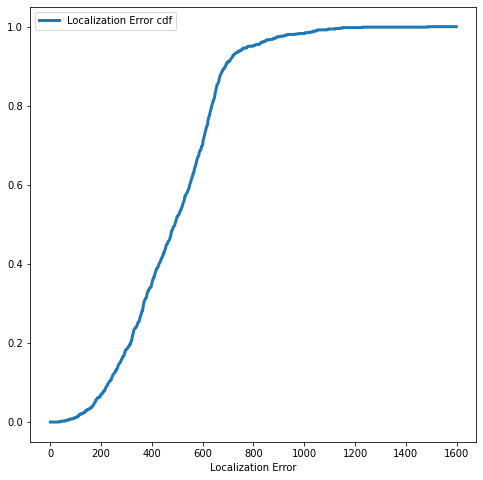

In [724]:
print(Before_Each_sumRMSE)
# print(np.array(Before_Each_sumMSE).flatten().tolist())
Before_sumRMSE = np.concatenate(([], np.array(Before_Each_sumRMSE).flatten().tolist()),axis=0)
# Before_sumRMSE = [np.log(y) for y in Before_sumRMSE]
print(Before_sumRMSE)
Before_RMSEHist, Before_bin_edges = np.histogram(Before_sumRMSE, bins=1000, range=(0, 1.6*1e3), density=True)
normalizeBefore_RMSEHist = Before_RMSEHist*np.diff(Before_bin_edges)

Before_cdf=np.cumsum(normalizeBefore_RMSEHist)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.plot(Before_bin_edges[:-1], Before_cdf, label = 'Localization Error cdf', linewidth=3.0)
# ax1.hist(Before_sumMSE, bins = 1000, label = 'Localization Error cdf', range=(0, 1.0*1e6), alpha = 0.5, cumulative=True, density=True)
ax1.legend()
ax1.set_xlabel('Localization Error')

In [725]:
After_Total_sumMSE = []
After_Total_sumRMSE = []
After_Each_sumMSE = []
After_Each_sumRMSE = []
for Sample in range(Samples):
  new_Nngps = len(SelectedTargets[Sample])
  new_Ngps = len(SelectedAnchors[Sample])
  sumMSE = []
  sumRMSE = []
  for i in range(new_Nngps):
    trueP = SelectedTargets[Sample][i].realPosition
    try:
      estimatedP = EstimatedPositionAfterAnomalyDetection[Sample][i]
    except:
      pass
    mse = MSE(trueP, estimatedP)
    rmse = np.sqrt(mse)
    # print("Targets: ", trueP, estimatedP, mse, rmse)
    sumMSE.append(mse)
    sumRMSE.append(rmse)
  for i in range(new_Ngps):
    trueP = SelectedAnchors[Sample][i].realPosition
    estimatedP = SelectedAnchors[Sample][i].observedPosition
    if not trueP == estimatedP:
      mse = MSE(trueP, estimatedP)
      rmse = np.sqrt(mse)
      # print("Anchors: ", trueP, estimatedP, mse, rmse)
      sumMSE.append(mse)
      sumRMSE.append(rmse)
  After_Total_sumMSE.append(sum(sumMSE))
  After_Each_sumMSE.append(sumMSE)
  After_Total_sumRMSE.append(sum(sumRMSE))
  After_Each_sumRMSE.append(sumRMSE)

avg_sumMSE = np.mean(After_Total_sumMSE)/env.N
avg_sumRMSE = np.mean(After_Total_sumRMSE)/env.N
print("Average MSE: {}, RMSE: {}.".format(avg_sumMSE, avg_sumRMSE))

try:
  os.makedirs(rootpath+'/datas/localizationResult')
except OSError as error:
  print(error)


# np.save(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}'.format(div, pick, model), avg_sumMSE)
# np.save(rootpath+'/datas/localizationResult/after_localization_avgRMSE{}_{}_{}'.format(div, pick, model), avg_sumRMSE)
f = open(rootpath+'/datas/localizationResult/0804_after_localization_avgRMSE{}_{}_{}_v2.pkl'.format(div, pick, model), "wb")
pickle.dump(avg_sumRMSE, f)
f.close()

# np.save(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}'.format(div, pick, model), After_Each_sumMSE)
# np.save(rootpath+'/datas/localizationResult/after_localization_RMSE{}_{}_{}'.format(div, pick, model), After_Each_sumRMSE)

# f = open(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}.pkl'.format(div, pick, model), "wb")
# pickle.dump(After_Each_sumMSE, f)
# f.close()

f = open(rootpath+'/datas/localizationResult/0804_after_localization_RMSE{}_{}_{}_v2.pkl'.format(div, pick, model), "wb")
pickle.dump(After_Each_sumRMSE, f)
f.close()

Average MSE: 110249.69563831584, RMSE: 228.09946037234263.
[Errno 17] File exists: '/content/drive/Shareddrives/KW phase1 repo/datas/localizationResult'


[[272.60744670600207, 304.53447906194054, 259.03394060701095, 115.96823197617373, 391.07511830854065, 533.7582534715085, 415.048864242691, 405.5554947470145, 169.16639079551035, 587.5797818169036, 475.5365390798062, 645.632248265218], [720.0907528804494, 610.6526107733754, 793.9927570420537, 770.2535529020249, 742.7982028697758, 600.9183172732511, 813.9297498686965, 348.69214822745283, 546.3479434978817, 699.3334795074122, 540.1110996822783], [334.38222011859506, 306.443635314887, 252.83076022006261, 320.60122704026065, 267.3902402591945, 331.99178949349954, 335.250263709553, 478.74989219466374, 285.584426119147, 630.2956978011723, 566.8347789847292], [308.03264359386947, 76.89306624583034, 381.2855022876706, 192.3204466469101, 55.65198020172876, 76.60025429656581, 74.9999004696646, 147.7480194704736, 254.431240517673, 132.77234613495534, 620.4659539410684], [126.96678486424564, 62.58771972447428, 47.15331220599286, 303.9891854942477, 45.749580798188255, 313.3492492221016, 122.68674498

Text(0.5, 0, 'Localization Error')

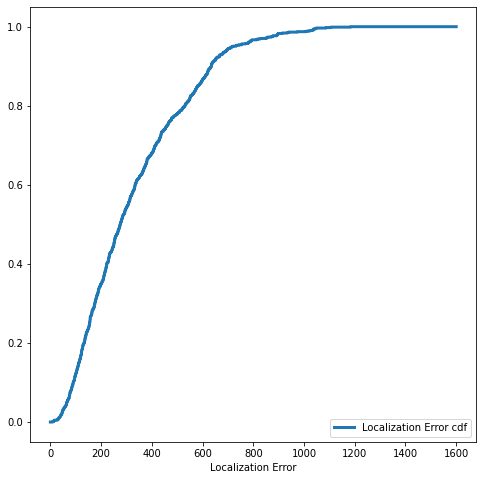

In [726]:
# After_Each_sumRMSE = np.load(rootpath+'/datas/localizationResult/after_localization_RMSE{}_{}_{}.npy'.format(div, pick, model), allow_pickle=True)
print(After_Each_sumRMSE)
from functools import reduce
from operator import add
After_sumRMSE = reduce(add ,After_Each_sumRMSE)
# print(np.array(After_Each_sumMSE).reshape(-1))
# After_sumMSE = np.concatenate(([], np.array(After_Each_sumMSE).flatten().tolist()),axis=0)
# After_sumRMSE = [np.log(y) for y in After_sumRMSE]
print(After_sumRMSE)
After_RMSEHist, After_bin_edges = np.histogram(After_sumRMSE, bins=50000, range=(0, 1.6*1e3), density=True)
normalizeAfter_RMSEHist = After_RMSEHist*np.diff(After_bin_edges)

After_cdf=np.cumsum(normalizeAfter_RMSEHist)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.plot(After_bin_edges[:-1], After_cdf, label = 'Localization Error cdf', linewidth=3.0)
# ax1.hist(After_sumMSE, bins = 10000, label = 'Localization Error cdf', alpha = 0.5, range=(0, 0.06*1e6), cumulative=True, density=True)
ax1.legend(loc='lower right')
ax1.set_xlabel('Localization Error')

Text(0, 0.5, 'CDF')

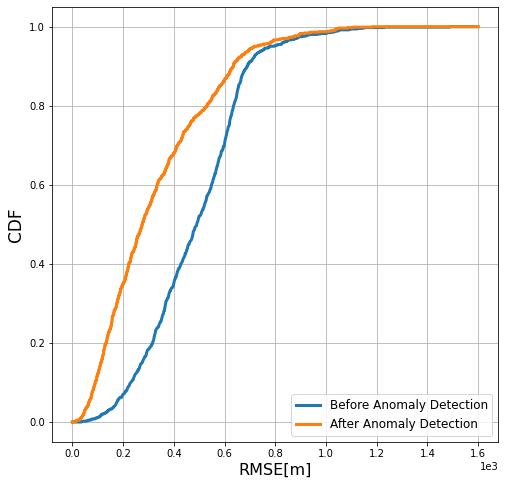

In [727]:
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
plt.grid()
ax1.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
ax1.plot(Before_bin_edges[:-1], Before_cdf, label = 'Before Anomaly Detection', linewidth=3.0)
ax1.plot(After_bin_edges[:-1], After_cdf, label = 'After Anomaly Detection', linewidth=3.0)
# ax1.hist(Before_sumMSE, bins = 1000, label = 'Localization Error cdf', range=(0, 1.0*1e6), alpha = 0.5, cumulative=True, density=True)
ax1.legend(loc='lower right', prop={'size': 12})
ax1.set_xlabel('RMSE[m]', fontsize=16)
ax1.set_ylabel('CDF', fontsize=17)
# plt.savefig("Log-RMSE.svg")
# plt.savefig(rootpath+'/datas/localizationResult/Log-RMSE{}_{}_{}.svg'.format(div, pick, model))